## Import

In [ ]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git 
!pip install -U git+https://github.com/albumentations-team/albumentations 
!pip install --upgrade opencv-contrib-python 

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 8.77 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-dfojr7rk
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-dfojr7rk
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125709 sha256=c80b16d0fb4d37c44fcb0519065b40199bfdd914cee8c1d59a1e064aed58cc60
  Stored in directory: /tmp/pip-ephem-wheel

In [ ]:
import sys 
sys.path.append('/content/GradCAM-Dataset')

In [ ]:
from google.colab.patches import cv2_imshow

# import require lib

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import models, datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2


import torch.nn.functional as F

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import cv2


from torchvision import datasets, transforms as T

import albumentations as A 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

In [ ]:
import os
from random import randint
import urllib
import zipfile

In [ ]:
from skimage.transform import resize
import matplotlib as mpl

In [ ]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassAccuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 8.2 MB/s eta 0:00:00


# Device Agnostic code

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Load dataset

In [ ]:
### TEST IMAGE
!wget https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492_960_720.jpg
!mv cat-2083492_960_720.jpg cat_img.jpg

--2023-05-07 21:19:03--  https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.14.16, 104.18.15.16, 2606:4700::6812:f10, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.14.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143134 (140K) [binary/octet-stream]
Saving to: ‘cat-2083492_960_720.jpg’

cat-2083492_960_720 100%[===================>] 139.78K  --.-KB/s    in 0.009s  

2023-05-07 21:19:03 (15.9 MB/s) - ‘cat-2083492_960_720.jpg’ saved [143134/143134]



In [ ]:
# Retrieve data directly from Stanford data source
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
  
# Unzip raw zip file
!unzip -qq 'tiny-imagenet-200.zip'

# Define main data directory
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

--2023-05-07 21:19:04--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  20.0MB/s    in 18s     

2023-05-07 21:19:21 (13.5 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')

# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Display first 10 entries of resulting val_img_dict dictionary
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429'}

In [ ]:
# Create subfolders (if not present) for validation images based on label,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [ ]:
image_transform_pretrain = transforms.Compose([
                transforms.Resize(224), # Resize images to 64 x 64
                # transforms.CenterCrop(56), # Center crop image
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),  # Images to tensors
                # transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                #                      std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform = image_transform_pretrain)
valid_dataset = datasets.ImageFolder(val_img_dir, transform = image_transform_pretrain)

In [ ]:
num_classes = len(train_dataset.classes)
num_classes

200

In [ ]:
# Define batch size for DataLoaders
BATCH_SIZE = 32

# Create DataLoaders for pre-trained models (normalized based on specific requirements)
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                              shuffle = True, drop_last = True)

valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, 
                              drop_last = True)

## Visualize dataset

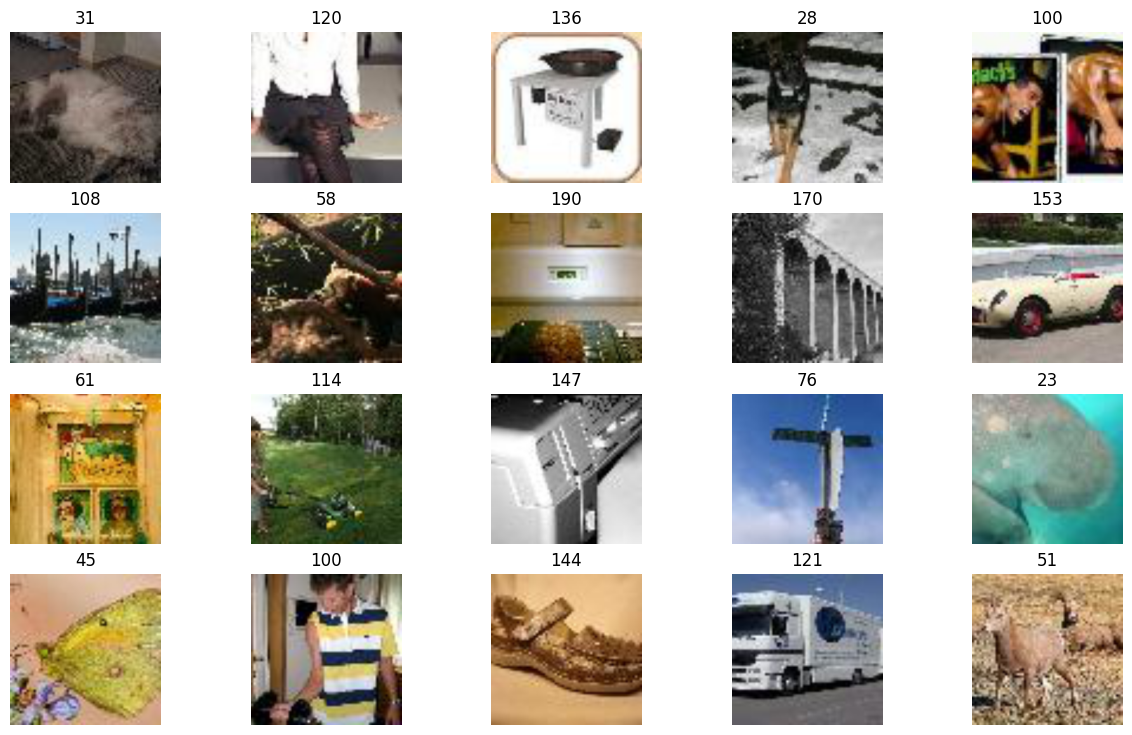

In [ ]:
torch.manual_seed(64)
plt.figure(figsize=(15,9))
row, col = 4, 5

for i in range(1, row*col+1):
  random_idx = torch.randint(0, len(train_dataset), size = [1]).item()
  image, label = train_dataset[random_idx]
  plt.subplot(row, col, i)
  plt.imshow(image.permute(1, 2, 0))
  plt.title(label)
  plt.axis(False)

In [ ]:
def imshow(img):
    npimg = img[0].numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(img[1])
    plt.show()

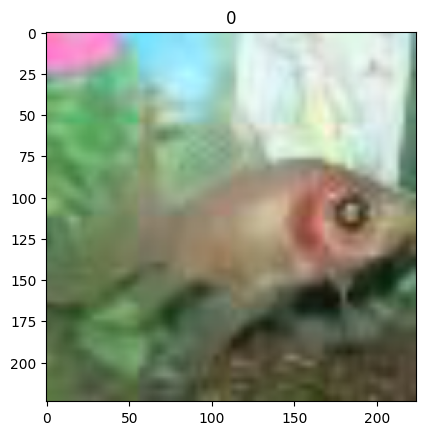

In [ ]:
imshow(train_dataset[0])

# Build model

## Simple CNN architecture

## take simple dataset

In [ ]:
CSV_FILE = "/content/GradCAM-Dataset/train.csv"
DATA_DIR = "/content/GradCAM-Dataset/"

# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [ ]:
data = pd.read_csv(CSV_FILE)
data.head()

img_path  label
0  train_images/mushroom_51.jpg      2
1  train_images/eggplant_37.jpg      1
2  train_images/mushroom_20.jpg      2
3  train_images/eggplant_51.jpg      1
4  train_images/eggplant_26.jpg      1

In [ ]:
train_df, valid_df = train_test_split(data, test_size = 0.2, random_state = 64)

In [ ]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

valid_augs = A.Compose([
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [ ]:
trainset = utils.ImageDataset(train_df, augs = train_augs, data_dir = DATA_DIR)
validset = utils.ImageDataset(valid_df, augs = valid_augs, data_dir = DATA_DIR)

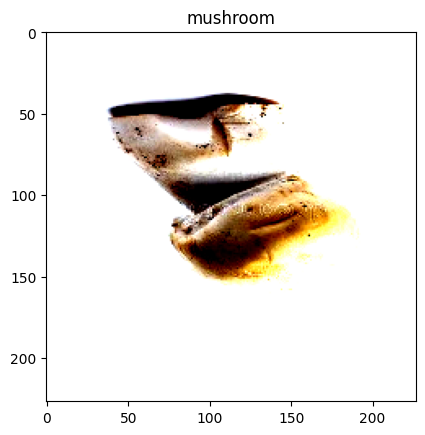

In [ ]:
image, label = trainset[0]

class_list = ['cucumber', 'eggplant', 'mushroom']

plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label]);

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

### Model

In [ ]:
class ImageModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (5, 5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4,4), stride = 2),
        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (5, 5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4,4), stride = 2),
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (5, 5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4,4), stride = 2),
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (5, 5), padding = 1),
        nn.ReLU(),
        # nn.MaxPool2d(kernel_size = (4,4), stride = 2),
    )

    self.maxpool = nn.MaxPool2d(kernel_size = (4,4), stride = 2)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6400, 2048),
        nn.ReLU(),
        nn.Linear(2048, 3)
    )

    self.gradient = None

  def activations_hook(self, grad):
    self.gradient = grad

  def forward(self, images):
    x = self.feature_extractor(images)

    h = x.register_hook(self.activations_hook)

    x = self.maxpool(x)
    x = self.classifier(x)

    return x

  def get_activation_gradients(self):
    return self.gradient

  def get_activation(self, x):
    return self.feature_extractor(x)

In [ ]:
torch.manual_seed(32)
model = ImageModel().to(device)
model

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

In [ ]:
def get_gradcam(model, image, label, size):

  label.backward()

  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim = [0,2,3])

  activations = model.get_activation(image).detach()

  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim = 1).squeeze().cpu() 
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)

  heatmap = cv2.resize(heatmap.numpy(), (size,size))

  return heatmap


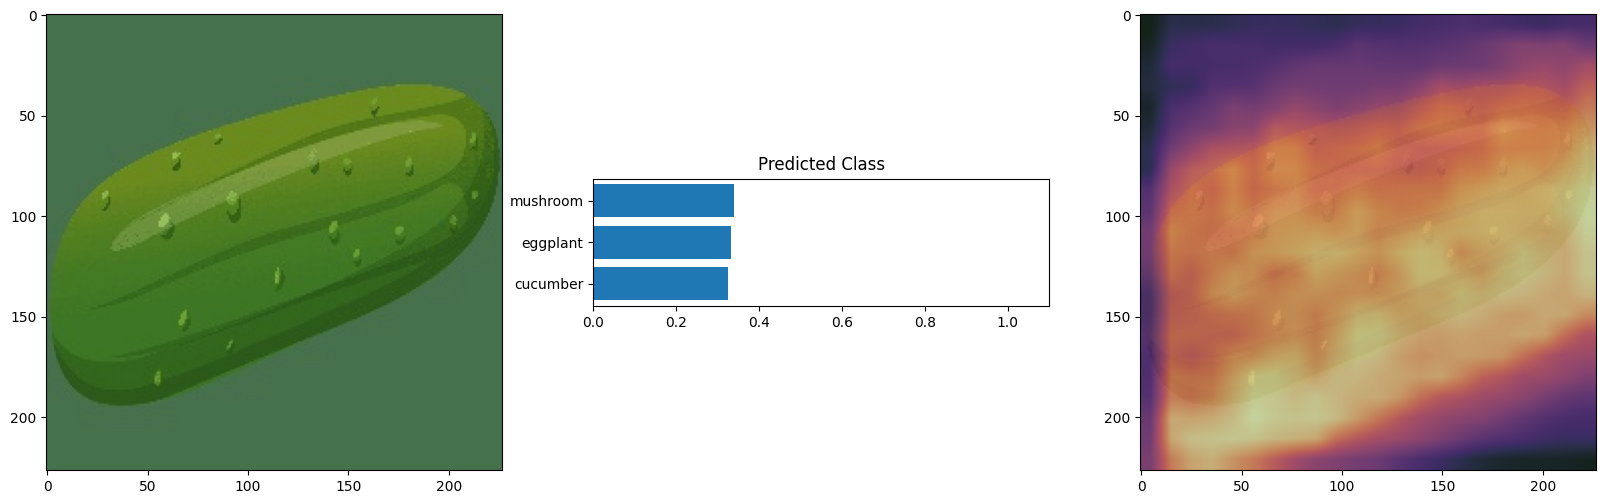

In [ ]:
image, label = validset[7]

denorm_image = image.permute(1, 2, 0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

image = image.unsqueeze(0).to(device)



pred = model(image)
heatmap = get_gradcam(model, image, pred[0][2], size = 227)
utils.plot_heatmap(denorm_image, pred, heatmap)


In [ ]:
# take some random index of imagenet dataset
images = [45357, 5829, 6271, 7032, 82485]

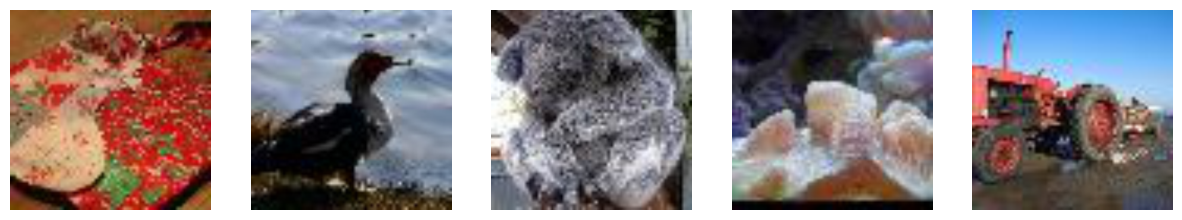

In [ ]:
plt.figure(figsize=(15,9))
row, col = 1, len(images)

for i in range(1, row*col+1):
  image, label = train_dataset[images[i-1]]
  plt.subplot(row, col, i)
  plt.imshow(image.permute(1, 2, 0))
  # plt.title(label)
  plt.axis(False)

## Resnet50

In [ ]:
# Define the pre-processing function
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

In [ ]:
# Define the Grad-CAM function
class GradCAM:
    def __init__(self, model, feature_layer):
        self.model = model
        self.feature_layer = feature_layer
        self.gradient = None
        self.activations = None
        self.hooks = []
        self._register_hooks()

    def _register_hooks(self):
        def hook_fn_forward(module, input, output):
            self.activations = output

        def hook_fn_backward(module, grad_out, grad_in):
            self.gradient = grad_out[0]

        for name, module in self.model.named_modules():
            if name == self.feature_layer:
                self.hooks.append(module.register_forward_hook(hook_fn_forward))
                self.hooks.append(module.register_backward_hook(hook_fn_backward))

    def _get_weights(self):
        return torch.mean(self.gradient, axis=(2, 3), keepdims=True)

    def generate(self, input_image, class_idx=None):
        output = self.model(input_image)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1)
        self.model.zero_grad()
        output[0][class_idx].backward()
        weights = self._get_weights()
        cam = torch.sum(weights * self.activations, axis=1, keepdims=True)
        cam = F.relu(cam)
        cam /= torch.max(cam)
        return cam.squeeze().detach().cpu().numpy()

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

In [ ]:
# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=False, progress = False)
# Set the model to evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### take random image from google

In [ ]:
!wget https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492_960_720.jpg
!mv cat-2083492_960_720.jpg cat_img.jpg

--2023-05-07 21:31:42--  https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.14.16, 104.18.15.16, 2606:4700::6812:f10, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.14.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143134 (140K) [binary/octet-stream]
Saving to: ‘cat-2083492_960_720.jpg’

cat-2083492_960_720 100%[===================>] 139.78K  --.-KB/s    in 0.008s  

2023-05-07 21:31:42 (16.7 MB/s) - ‘cat-2083492_960_720.jpg’ saved [143134/143134]



### Grad cam of ramdom image on resnet50

In [ ]:
# Load the input image and pre-process it
image_path = "/content/cat_img.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
image = image.astype(float)

input_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
input_image = input_image.to(dtype = torch.float)
# print(input_image.dtype)

# Initialize Grad-CAM and generate the heatmap
gradcam = GradCAM(model, 'layer4')
heatmap = gradcam.generate(input_image)

# Resize the heatmap to match the input image size
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

heatmap = heatmap.astype(float)
image = image.astype(float)

# Overlay the heatmap onto the input image
output = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
# Save the output image
cv2.imwrite("cat_output.jpg", output)
# plt.imshow(output)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True

(-0.5, 223.5, 223.5, -0.5)

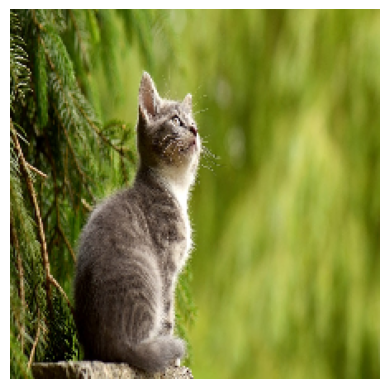

In [ ]:
plt.imshow(input_image.squeeze().permute(1,2,0)/255)
plt.axis(False)

(-0.5, 223.5, 223.5, -0.5)

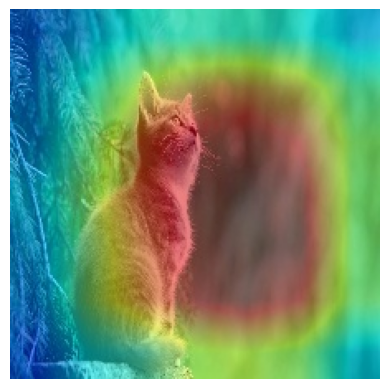

In [ ]:
# plt.imshow(output/255)
path = "/content/cat_output.jpg"
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
image = image.astype(float)

# print(image.shape)
input_image = torch.from_numpy(image)
input_image = input_image.to(dtype = torch.float)
# plt.subplot(row, col, i)
plt.imshow(input_image/255)
plt.axis(False)

In [ ]:
!wget https://cdn.pixabay.com/photo/2017/07/24/19/57/tiger-2535888_960_720.jpg
!wget https://cdn.pixabay.com/photo/2018/03/26/20/49/tiger-3264048_960_720.jpg
!wget https://www.wikihow.com/images/thumb/7/71/Take-Care-of-Your-Pet-Step-2-Version-3.jpg/aid799208-v4-728px-Take-Care-of-Your-Pet-Step-2-Version-3.jpg
!mv tiger-2535888_960_720.jpg tiger_img.jpg
!mv tiger-3264048_960_720.jpg tiger_img2.jpg
!mv aid799208-v4-728px-Take-Care-of-Your-Pet-Step-2-Version-3.jpg img2.jpg

--2023-05-07 21:31:44--  https://cdn.pixabay.com/photo/2017/07/24/19/57/tiger-2535888_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.14.16, 104.18.15.16, 2606:4700::6812:f10, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.14.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299243 (292K) [binary/octet-stream]
Saving to: ‘tiger-2535888_960_720.jpg’

tiger-2535888_960_7 100%[===================>] 292.23K  --.-KB/s    in 0.01s   

2023-05-07 21:31:44 (20.6 MB/s) - ‘tiger-2535888_960_720.jpg’ saved [299243/299243]

--2023-05-07 21:31:44--  https://cdn.pixabay.com/photo/2018/03/26/20/49/tiger-3264048_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.14.16, 104.18.15.16, 2606:4700::6812:f10, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.14.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155840 (152K) [binary/octet-stream]
Saving to: ‘tiger-3264048_960_720.jpg’

tiger-3264048_96

In [ ]:
# Load the input image and pre-process it
image_path = "/content/img2.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
image = image.astype(float)

input_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
input_image = input_image.to(dtype = torch.float)
# print(input_image.dtype)

# Initialize Grad-CAM and generate the heatmap
gradcam = GradCAM(model, 'layer4')
heatmap = gradcam.generate(input_image)

# Resize the heatmap to match the input image size
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

heatmap = heatmap.astype(float)
image = image.astype(float)

# Overlay the heatmap onto the input image
output_tiger = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
# Save the output image
cv2.imwrite("mulit_obj_cat_output.jpg", output_tiger)
# plt.imshow(output)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True

(-0.5, 223.5, 223.5, -0.5)

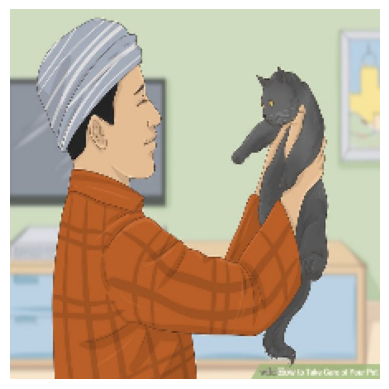

In [ ]:
plt.imshow(input_image.squeeze().permute(1,2,0)/255)
plt.axis(False)

(-0.5, 223.5, 223.5, -0.5)

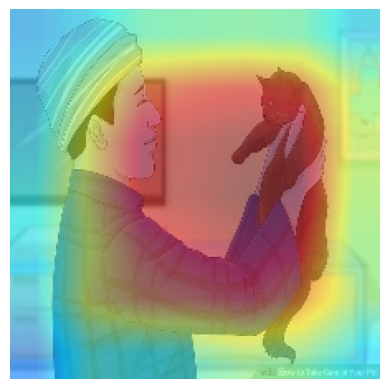

In [ ]:
# plt.imshow(output_tiger/225)
# plt.imshow(output/255)
path = "/content/mulit_obj_cat_output.jpg"
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
image = image.astype(float)

# print(image.shape)
input_image = torch.from_numpy(image)
input_image = input_image.to(dtype = torch.float)
# plt.subplot(row, col, i)
plt.imshow(input_image/255)
plt.axis(False)

### take random images from datasest an aply grad cam on it with resnet50 model

In [ ]:
# Load the input image and pre-process it
for i in range(len(images)):
  # random_idx = torch.randint(0, len(train_dataset), size = [1]).item()
  data_image = train_dataset[images[i]][0]
  input_image = data_image.unsqueeze(0)
  # print(input_image.shape)
  # print(input_image.dtype)

  data_image = data_image.to(dtype = torch.float64)
  image = data_image.cpu().permute(1, 2, 0).detach().numpy() * 255

  # print(image.shape)

  # Initialize Grad-CAM and generate the heatmap
  gradcam = GradCAM(model, 'layer4')
  heatmap = gradcam.generate(input_image)
  # print(f"1: {heatmap.shape}")

  # Resize the heatmap to match the input image size
  heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

  # print(f"2: {heatmap.shape}")

  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


  # print(image)
  # print(heatmap)
  # print(image.shape, type(image), image.dtype)
  # print(heatmap.shape, type(heatmap), heatmap.dtype)
  # print()
  heatmap = heatmap.astype(float)
  # image = image.astype(float)


  # Overlay the heatmap onto the input image
  output_resnet50 = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
  # Save the output image
  # plt.imshow(output_resnet50/255)
  cv2.imwrite(f"{'output_resnet50_'+str(images[i])+'.jpg'}", output_resnet50)

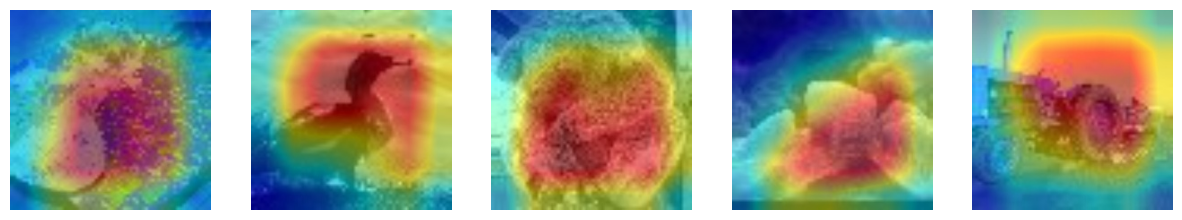

In [ ]:
res_grad_imgs = ["/content/output_resnet50_45357.jpg", "/content/output_resnet50_5829.jpg", "/content/output_resnet50_6271.jpg", "/content/output_resnet50_7032.jpg", "/content/output_resnet50_82485.jpg"]
plt.figure(figsize=(15,9))
row, col = 1, len(images)

for i in range(1, row*col+1):
  image = cv2.imread(res_grad_imgs[i-1])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
  image = image.astype(float)

  # print(image.shape)
  input_image = torch.from_numpy(image)
  input_image = input_image.to(dtype = torch.float)
  plt.subplot(row, col, i)
  plt.imshow(input_image/255)
  # plt.title(label)
  plt.axis(False)

## Multi attention resnet50

In [ ]:
# import torch.nn.functional as F
class Attention(torch.nn.Module):
    """
    Attention block for CNN model.
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(Attention, self).__init__()
        self.conv_depth = torch.nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, groups=in_channels)
        self.conv_point = torch.nn.Conv2d(out_channels, out_channels, kernel_size=(1, 1))
        self.bn = torch.nn.BatchNorm2d(out_channels, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.activation = torch.nn.Tanh()
    def forward(self, inputs):
        x, output_size = inputs
        x = F.adaptive_max_pool2d(x, output_size=output_size)
        print(f"conv_x : {x.shape}")
        x = self.conv_depth(x)
        x = self.conv_point(x)
        x = self.bn(x)
        x = self.activation(x) + 1.0
        return x


class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels // 8, in_channels, kernel_size=1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        avg_out = self.avgpool(out)
        max_out = self.maxpool(out)
        out = avg_out + max_out
        out = self.sigmoid(out)
        return x * out

class ResNet50Attention(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet50Attention, self).__init__()
        self.resnet = torchvision.models.resnet50(pretrained=False, progress = False)
        self.attention_block1 = AttentionBlock(256)
        self.attention_block2 = AttentionBlock(512)
        self.attention_block3 = AttentionBlock(1024)
        self.attention_block4 = AttentionBlock(2048)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.attention_block1(x)

        x = self.resnet.layer2(x)
        x = self.attention_block2(x)

        x = self.resnet.layer3(x)
        x = self.attention_block3(x)

        x = self.resnet.layer4(x)
        x = self.attention_block4(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Instantiate the ResNet50Attention model


In [ ]:
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchsummary import summary

att_resnet50 = ResNet50Attention()
summary(att_resnet50, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1                              []                        --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
├─AttentionBlock: 1-1                    [-1, 256, 56, 56]         --
|    └─Conv2d: 2-6                       [-1, 32, 56, 56]          8,224
|    └─Conv2d: 2-7                       [-1, 256, 56, 56]         8,448
|    └─AdaptiveAvgPool2d: 2-8            [-1, 256, 1, 1]       

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1                              []                        --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
├─AttentionBlock: 1-1                    [-1, 256, 56, 56]         --
|    └─Conv2d: 2-6                       [-1, 32, 56, 56]          8,224
|    └─Conv2d: 2-7                       [-1, 256, 56, 56]         8,448
|    └─AdaptiveAvgPool2d: 2-8            [-1, 256, 1, 1]       

In [ ]:
att_resnet50

ResNet50Attention(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [ ]:
class Attention_GradCAM:
    def __init__(self, model, feature_layer):
        self.model = model
        self.feature_layer = feature_layer
        self.gradient = None
        self.activations = None
        self.hooks = []
        self._register_hooks()

    def _register_hooks(self):
        def hook_fn_forward(module, input, output):
            self.activations = output

        def hook_fn_backward(module, grad_out, grad_in):
            self.gradient = grad_out[0]

        for name, module in self.model.named_modules():
            if name == self.feature_layer:
                self.hooks.append(module.register_forward_hook(hook_fn_forward))
                self.hooks.append(module.register_backward_hook(hook_fn_backward))

    def _get_weights(self):
      if self.gradient is None:
          raise ValueError("Gradient is None. Backward hook did not execute.")
      return torch.mean(self.gradient, dim=(2, 3), keepdim=True)

    def generate(self, input_image, class_idx=None):
        output = self.model(input_image)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1)
        self.model.zero_grad()
        output[0][class_idx].backward()
        weights = self._get_weights()
        cam = torch.sum(weights * self.activations, axis=1, keepdim=True)
        cam = F.relu(cam)
        cam /= torch.max(cam)
        return cam.squeeze().detach().cpu().numpy()

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

### Grad cam of random image on multi attention resnet50

In [ ]:
# Load the input image and pre-process it
image_path = "/content/cat_img.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
image = image.astype(float)

input_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
input_image = input_image.to(dtype=torch.float32)

# Initialize Grad-CAM and generate the heatmap
attention_gradcam = Attention_GradCAM(att_resnet50, 'attention_block4')
heatmap = attention_gradcam.generate(input_image)

# Resize the heatmap to match the input image size
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

heatmap = heatmap.astype(float)
image = image.astype(float)

# Overlay the heatmap onto the input image
output_ma_resnet50 = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

# Save the output image
cv2.imwrite("output_at_4.jpg", output_ma_resnet50)

True

(-0.5, 223.5, 223.5, -0.5)

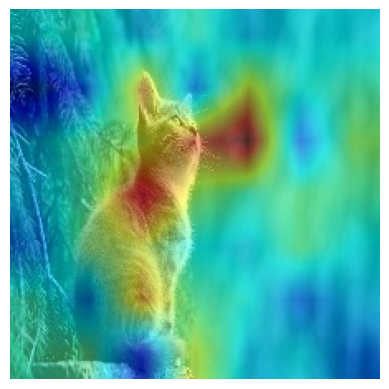

In [ ]:
# plt.imshow(output_ma_resnet50/255)
# plt.imshow(output/255)
path = "/content/output_at_4.jpg"
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
image = image.astype(float)

# print(image.shape)
input_image = torch.from_numpy(image)
input_image = input_image.to(dtype = torch.float)
# plt.subplot(row, col, i)
plt.imshow(input_image/255)
plt.axis(False)

## Multiattention resnet50 on multiple object

In [ ]:
# Load the input image and pre-process it
image_path = "/content/img2.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
image = image.astype(float)

input_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
input_image = input_image.to(dtype=torch.float32)

# Initialize Grad-CAM and generate the heatmap
attention_gradcam = Attention_GradCAM(att_resnet50, 'attention_block4')
heatmap = attention_gradcam.generate(input_image)

# Resize the heatmap to match the input image size
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

heatmap = heatmap.astype(float)
image = image.astype(float)

# Overlay the heatmap onto the input image
output_ma_resnet50 = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

# Save the output image
cv2.imwrite("MO_output_at_4.jpg", output_ma_resnet50)

True

(-0.5, 223.5, 223.5, -0.5)

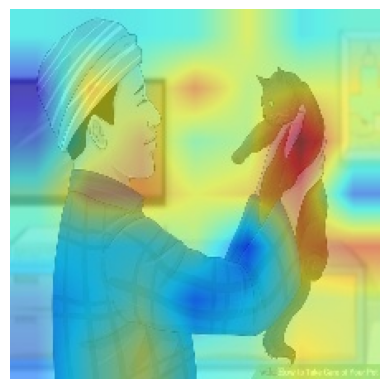

In [ ]:
# plt.imshow(output_ma_resnet50/255)
# plt.imshow(output_ma_resnet50/255)
# plt.imshow(output/255)
path = "/content/MO_output_at_4.jpg"
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
image = image.astype(float)

# print(image.shape)
input_image = torch.from_numpy(image)
input_image = input_image.to(dtype = torch.float)
# plt.subplot(row, col, i)
plt.imshow(input_image/255)
plt.axis(False)

## Multiattention resnet50 on dataset random images

In [ ]:
# Load the input image and pre-process it
for i in range(len(images)):
  # random_idx = torch.randint(0, len(train_dataset), size = [1]).item()
  data_image = train_dataset[images[i]][0]
  input_image = data_image.unsqueeze(0)
  # print(input_image.shape)
  # print(input_image.dtype)

  data_image = data_image.to(dtype = torch.float64)
  image = data_image.cpu().permute(1, 2, 0).detach().numpy() * 255

  # print(image.shape)
  # Initialize Grad-CAM and generate the heatmap
  attention_gradcam = Attention_GradCAM(att_resnet50, 'attention_block4')
  heatmap = attention_gradcam.generate(input_image)

  # Resize the heatmap to match the input image size
  heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  heatmap = heatmap.astype(float)
  image = image.astype(float)

  # Overlay the heatmap onto the input image
  output_ma_resnet50 = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

  # plt.imshow(output_ma_resnet50/255)
  # Save the output image
  cv2.imwrite(f"{'output_ma_resnet50_'+str(images[i])+'.jpg'}", output_ma_resnet50)

  

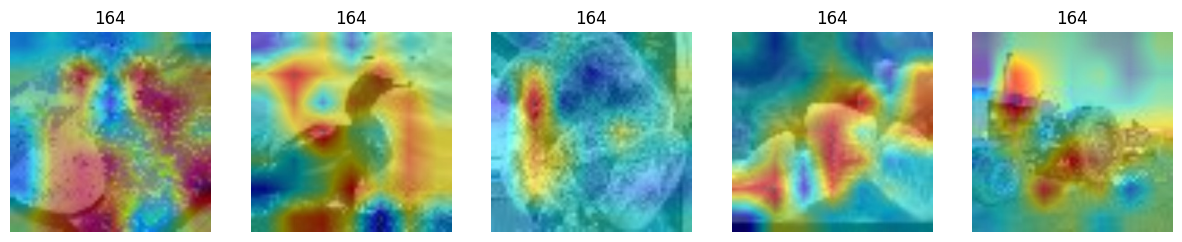

In [ ]:
at_res_grad_imgs = ["/content/output_ma_resnet50_45357.jpg", "/content/output_ma_resnet50_5829.jpg", "/content/output_ma_resnet50_6271.jpg", "/content/output_ma_resnet50_7032.jpg", "/content/output_ma_resnet50_82485.jpg"]
plt.figure(figsize=(15,9))
row, col = 1, len(at_res_grad_imgs)

for i in range(1, row*col+1):
  image = cv2.imread(at_res_grad_imgs[i-1])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
  image = image.astype(float)

  # print(image.shape)
  input_image = torch.from_numpy(image)
  input_image = input_image.to(dtype = torch.float)
  plt.subplot(row, col, i)
  plt.imshow(input_image/255)
  plt.title(label)
  plt.axis(False)

# Application

# noise / adversarial attack in image

## resnet50

In [ ]:
# Load the input image and pre-process it
image_path = "/content/cat_img.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
image = image.astype(float)

input_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
input_image = input_image.to(dtype = torch.float)
# print(input_image.dtype)

# noise in image
input_image += torch.randn_like(input_image)*32

# Initialize Grad-CAM and generate the heatmap
gradcam = GradCAM(model, 'layer4')
heatmap = gradcam.generate(input_image)

# Resize the heatmap to match the input image size
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

heatmap = heatmap.astype(float)
image = image.astype(float)

# Overlay the heatmap onto the input image
output = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
# Save the output image
cv2.imwrite("noise_output.jpg", output)
# plt.imshow(output)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True

(-0.5, 223.5, 223.5, -0.5)

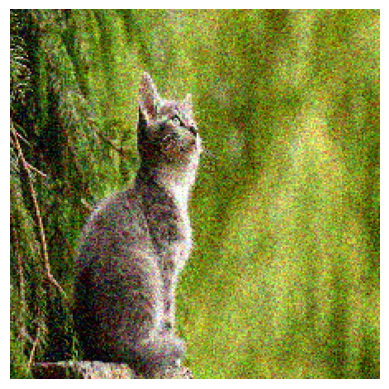

In [ ]:
plt.imshow(input_image.squeeze().permute(1,2,0)/255)
plt.axis(False)

(-0.5, 223.5, 223.5, -0.5)

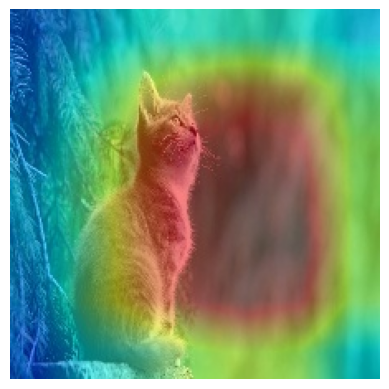

In [ ]:
# plt.imshow(output/255)
# plt.imshow(output_ma_resnet50/255)
# plt.imshow(output_ma_resnet50/255)
# plt.imshow(output/255)
path = "/content/noise_output.jpg"
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
image = image.astype(float)

# print(image.shape)
input_image = torch.from_numpy(image)
input_image = input_image.to(dtype = torch.float)
# plt.subplot(row, col, i)
plt.imshow(input_image/255)
plt.axis(False)

## multi attention 

In [ ]:
# Load the input image and pre-process it
image_path = "/content/cat_img.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
image = image.astype(float)

input_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
input_image = input_image.to(dtype=torch.float32)


# noise in image
input_image += torch.randn_like(input_image)*32

# Initialize Grad-CAM and generate the heatmap
attention_gradcam = Attention_GradCAM(att_resnet50, 'attention_block4')
heatmap = attention_gradcam.generate(input_image)

# Resize the heatmap to match the input image size
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

heatmap = heatmap.astype(float)
image = image.astype(float)

# Overlay the heatmap onto the input image
output_ma_resnet50 = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

# Save the output image
cv2.imwrite("noise_output_at_4.jpg", output_ma_resnet50)

True

(-0.5, 223.5, 223.5, -0.5)

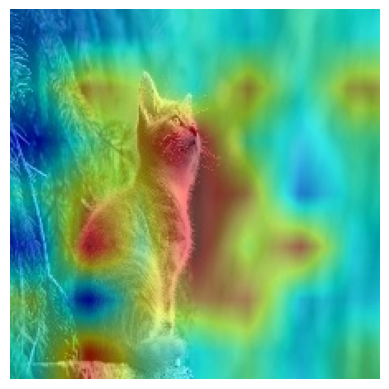

In [ ]:
# plt.imshow(output_ma_resnet50/255)
# plt.imshow(output_ma_resnet50/255)
# plt.imshow(output_ma_resnet50/255)
# plt.imshow(output/255)
path = "/content/noise_output_at_4.jpg"
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
image = image.astype(float)

# print(image.shape)
input_image = torch.from_numpy(image)
input_image = input_image.to(dtype = torch.float)
# plt.subplot(row, col, i)
plt.imshow(input_image/255)
plt.axis(False)

# On Adversarial patches

## get image

In [ ]:
!wget https://global.discourse-cdn.com/boingboing/original/3X/b/4/b48e36d5ef8e914d311192797e77f5362cf66c31.jpg
!wget https://github.com/jhayes14/adversarial-patch/raw/master/1981_859_adversarial.png
!wget https://github.com/jhayes14/adversarial-patch/raw/master/1978_859_adversarial.png
!wget https://miro.medium.com/v2/resize:fit:640/format:webp/1*DWylA3Jd0E1feifx81yJIQ.jpeg

!mv b48e36d5ef8e914d311192797e77f5362cf66c31.jpg adversarial_patch_1.jpg
!mv 1981_859_adversarial.png adversarial_patch_2.jpg
!mv 1978_859_adversarial.png adversarial_patch_3.jpg
!mv 1*DWylA3Jd0E1feifx81yJIQ.jpeg adversarial_patch_4.jpg

--2023-05-07 21:32:08--  https://global.discourse-cdn.com/boingboing/original/3X/b/4/b48e36d5ef8e914d311192797e77f5362cf66c31.jpg
Resolving global.discourse-cdn.com (global.discourse-cdn.com)... 13.35.7.63, 13.35.7.74, 13.35.7.116, ...
Connecting to global.discourse-cdn.com (global.discourse-cdn.com)|13.35.7.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91346 (89K) [image/jpeg]
Saving to: ‘b48e36d5ef8e914d311192797e77f5362cf66c31.jpg’

b48e36d5ef8e914d311 100%[===================>]  89.21K  --.-KB/s    in 0.04s   

2023-05-07 21:32:08 (2.48 MB/s) - ‘b48e36d5ef8e914d311192797e77f5362cf66c31.jpg’ saved [91346/91346]

--2023-05-07 21:32:08--  https://github.com/jhayes14/adversarial-patch/raw/master/1981_859_adversarial.png
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jhayes14/adversarial-pa

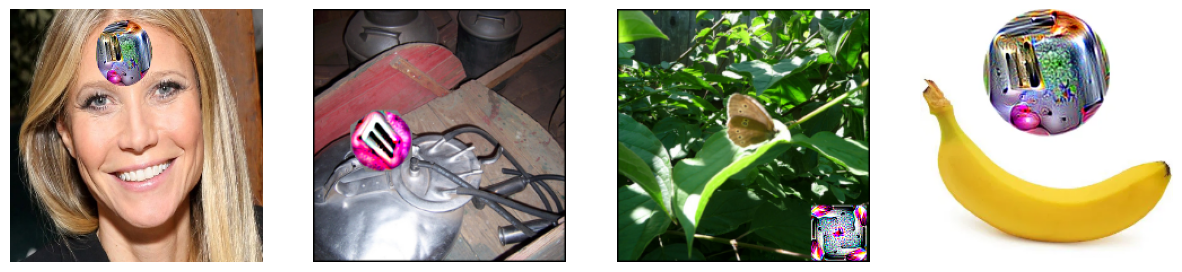

In [ ]:
ad_patches_img = ["/content/adversarial_patch_1.jpg", "/content/adversarial_patch_2.jpg", "/content/adversarial_patch_3.jpg", "/content/adversarial_patch_4.jpg"]
plt.figure(figsize=(15,9))
row, col = 1, len(ad_patches_img)

for i in range(1, row*col+1):
  image = cv2.imread(ad_patches_img[i-1])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
  image = image.astype(float)

  # print(image.shape)
  input_image = torch.from_numpy(image)
  input_image = input_image.to(dtype = torch.float)
  plt.subplot(row, col, i)
  plt.imshow(input_image/255)
  # plt.title(label)
  plt.axis(False)

In [ ]:
## Resnet 50

In [ ]:
# Load the input image and pre-process it
for i in range(len(ad_patches_img)):
  image_path = ad_patches_img[i]
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
  image = image.astype(float)

  input_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
  input_image = input_image.to(dtype = torch.float)
  # print(input_image.dtype)

  # Initialize Grad-CAM and generate the heatmap
  gradcam = GradCAM(model, 'layer4')
  heatmap = gradcam.generate(input_image)

  # Resize the heatmap to match the input image size
  heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  heatmap = heatmap.astype(float)
  image = image.astype(float)

  # Overlay the heatmap onto the input image
  output = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
  # Save the output image
  cv2.imwrite(f"ad_Patch_res_output_{i+1}.jpg", output)
# plt.imshow(output)

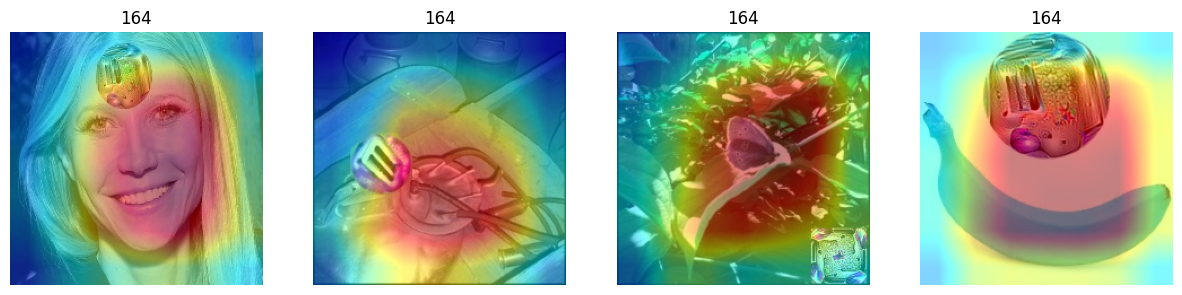

In [ ]:
ad_patches_out_img = ["/content/ad_Patch_res_output_1.jpg", "/content/ad_Patch_res_output_2.jpg", "/content/ad_Patch_res_output_3.jpg", "/content/ad_Patch_res_output_4.jpg"]
plt.figure(figsize=(15,9))
row, col = 1, len(ad_patches_out_img)

for i in range(1, row*col+1):
  image = cv2.imread(ad_patches_out_img[i-1])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
  image = image.astype(float)

  # print(image.shape)
  input_image = torch.from_numpy(image)
  input_image = input_image.to(dtype = torch.float)
  plt.subplot(row, col, i)
  plt.imshow(input_image/255)
  plt.title(label)
  plt.axis(False)

## mutliattention Resnet50

In [ ]:
# Load the input image and pre-process it
for i in range(len(ad_patches_img)):
  image_path = ad_patches_img[i]
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
  image = image.astype(float)

  input_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
  input_image = input_image.to(dtype=torch.float32)


  # Initialize Grad-CAM and generate the heatmap
  attention_gradcam = Attention_GradCAM(att_resnet50, 'attention_block4')
  heatmap = attention_gradcam.generate(input_image)

  # Resize the heatmap to match the input image size
  heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  heatmap = heatmap.astype(float)
  image = image.astype(float)

  # Overlay the heatmap onto the input image
  output_ma_resnet50 = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

  # Save the output image
  cv2.imwrite(f"ad_patch_output_at_{i+1}.jpg", output_ma_resnet50)

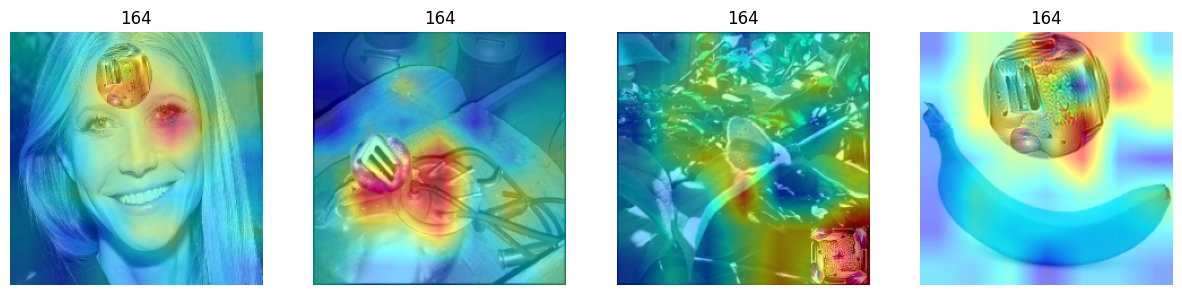

In [ ]:
ad_patches_out_img = ["/content/ad_patch_output_at_1.jpg", "/content/ad_patch_output_at_2.jpg", "/content/ad_patch_output_at_3.jpg", "/content/ad_patch_output_at_4.jpg"]
plt.figure(figsize=(15,9))
row, col = 1, len(ad_patches_out_img)

for i in range(1, row*col+1):
  image = cv2.imread(ad_patches_out_img[i-1])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
  image = image.astype(float)

  # print(image.shape)
  input_image = torch.from_numpy(image)
  input_image = input_image.to(dtype = torch.float)
  plt.subplot(row, col, i)
  plt.imshow(input_image/255)
  plt.title(label)
  plt.axis(False)